<a href="https://colab.research.google.com/github/LuritoCosta/caseZup/blob/main/case_Itau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_excel('/content/case_assessmentanalytics_vsabr2024.xlsx',sheet_name='Base_Avaliacao')
df_ref = pd.read_excel('/content/case_assessmentanalytics_vsabr2024.xlsx',sheet_name='Nivel_de_necessidade_po')

In [4]:
# ajustes do df_ref
df_ref = df_ref.drop('PAPEL', axis=1)
df_ref = pd.melt(df_ref, id_vars=['ESPECIALIDADE'], value_vars=df_ref.filter(regex=r'\[').columns).sort_values(by=['ESPECIALIDADE'])
df_ref['variable_ajust'] = df_ref['variable'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
df_ref['ESPECIALIDADE_ajust'] = df_ref['ESPECIALIDADE'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)

#ajuste do df_po
df_po = df[['Nome do colaborador avaliado','ESPECIALIDADE_avaliado','[Contexto estratégico] ',
            '[Problem solving]', '[Atitude de dono]', '[Poder de influência]',
            '[Produto como plataforma]', '[Mindset lean e ágil]',
            '[Product discovery]', '[Negócio e indústria]', '[P&L]', '[Dados]']][(df['Papel_comunidade'] == 'PO') & (df['ESPECIALIDADE_avaliado'].isin(['OPERAÇÕES', 'AQ DIGITAL', 'CRÉDITO', 'PRODUTO'])) & (df['Tipo de gestão'] == 'Funcional')]
df_po = pd.melt(df_po, id_vars=['ESPECIALIDADE_avaliado','Nome do colaborador avaliado'], value_vars=df_po.filter(regex=r'\[').columns).sort_values(by=['ESPECIALIDADE_avaliado','Nome do colaborador avaliado'])
df_po['variable_ajust'] = df_po['variable'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
df_po['ESPECIALIDADE_ajust'] = df_po['ESPECIALIDADE_avaliado'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
df_po = df_po.merge(df_ref, left_on=['ESPECIALIDADE_ajust', 'variable_ajust'],
            right_on=['ESPECIALIDADE_ajust', 'variable_ajust'],
            how='left')
df_po['diferenca'] = (df_po['value_y'] - df_po['value_x'])

In [11]:
df_po.columns

Index(['ESPECIALIDADE_avaliado', 'Nome do colaborador avaliado', 'variable_x',
       'value_x', 'variable_ajust', 'ESPECIALIDADE_ajust', 'ESPECIALIDADE',
       'variable_y', 'value_y', 'diferenca'],
      dtype='object')

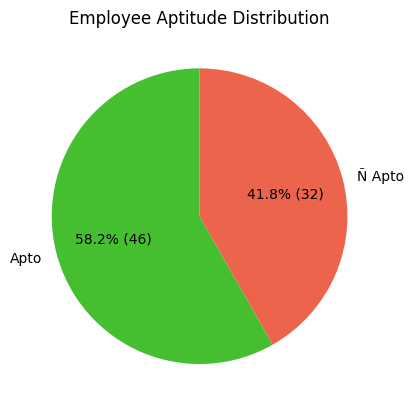

In [8]:
df_po_diff = df_po.groupby(['ESPECIALIDADE_avaliado','Nome do colaborador avaliado']).agg(total = ('diferenca','sum'))
df_po_diff['apto'] = np.where(df_po_diff['total']>= 0,'Apto','Ñ Apto')

# Assuming df_po_diff is already calculated as per your code
apto_counts = df_po_diff.groupby(['apto']).size()
colors = ['#45bf30', '#ed644c']  # Green and Red
plt.pie(apto_counts, labels=apto_counts.index, colors=colors, autopct=lambda pct: f"{pct:.1f}% ({int(pct/100.*apto_counts.sum())})", startangle=90)
plt.title('Employee Aptitude Distribution')
plt.show()

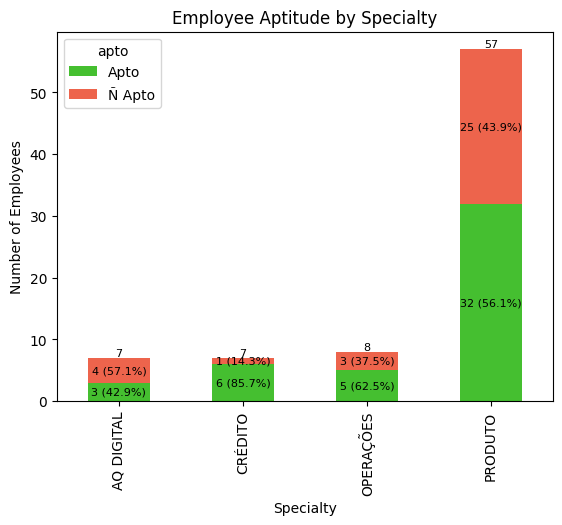

In [ ]:
df_po_diff = df_po.groupby(['ESPECIALIDADE_avaliado','Nome do colaborador avaliado']).agg(total = ('diferenca','sum'))
df_po_diff['apto'] = np.where(df_po_diff['total']>= 0,'Apto','Ñ Apto')
df_po_diff.groupby(['ESPECIALIDADE_avaliado','apto']).size()


df_plot = df_po_diff.groupby(['ESPECIALIDADE_avaliado','apto']).size().unstack().fillna(0)

# Plot the stacked bar chart
ax = df_plot.plot(kind='bar', stacked=True,color={'Ñ Apto': '#ed644c', 'Apto': '#45bf30'})

# Add labels for values and percentages, excluding zeros
for i, (index, row) in enumerate(df_plot.iterrows()):
    total = row.sum()
    for j, value in enumerate(row):
        if value != 0:  # Check for non-zero values
            percentage = (value / total) * 100
            ax.text(i, value/2 + row[:j].sum(), f"{int(value)} ({percentage:.1f}%)", ha='center', va='center', fontsize=8)

# Add labels for total counts on top of each column
for i, total in enumerate(df_plot.sum(axis=1)):
    ax.text(i, total, f"{int(total)}", ha='center', va='bottom', fontsize=8)

plt.title('Employee Aptitude by Specialty')
plt.xlabel('Specialty')
plt.ylabel('Number of Employees')
plt.show()

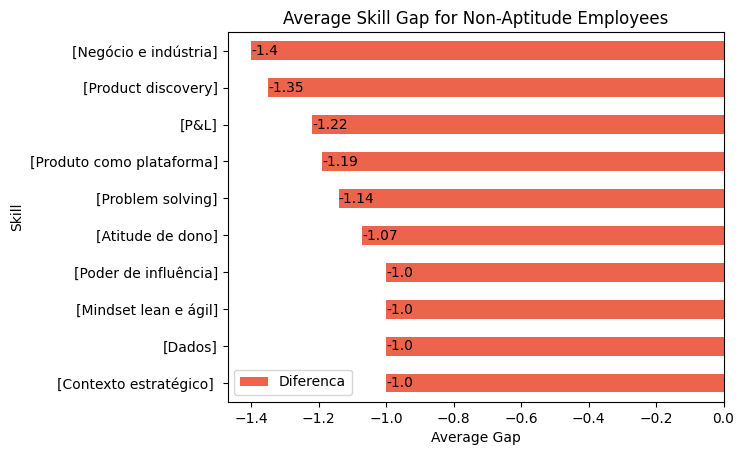

In [44]:
df_po_diff = df_po.groupby(['ESPECIALIDADE_avaliado','Nome do colaborador avaliado','variable_x']).agg(total = ('diferenca','sum'))
df_po_diff['apto'] = np.where(df_po_diff['total']>= 0,'Apto','Ñ Apto')
df_po_diff = df_po_diff[df_po_diff['apto'] == 'Ñ Apto'].groupby(['variable_x']).agg(Diferenca = ('total','mean')).round(2).sort_values(by=['Diferenca'],ascending=False)

colors = ['#ed644c'] * 3 + ['gray'] * (len(df_po_diff) - 3)
ax = df_po_diff.plot.barh(color=colors)
for i, v in enumerate(df_po_diff['Diferenca']):
    ax.text(v, i, str(v), color='black', va='center')
plt.title('Average Skill Gap for Non-Aptitude Employees')
plt.xlabel('Average Gap')
plt.ylabel('Skill')
plt.show()


# Começo da analise

## Primeira pergunta a ser respondida
  "1.Nossos POs estão aptos a exercer seus papeis?"

   Para conseguirmos responder esta pergunta temos como referencia o que é exigido para cada ESPECIALIDADE conforme o print abaixo:

   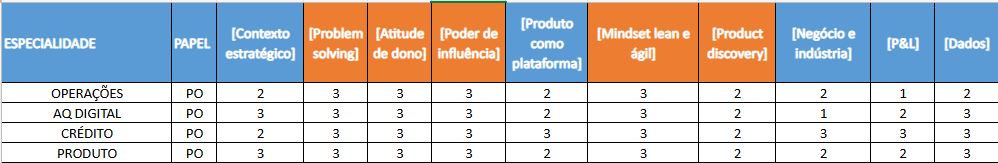

Fazendo uma analise exploratoria mais simples temos a quantidade de POs por especialidade da referencia de:

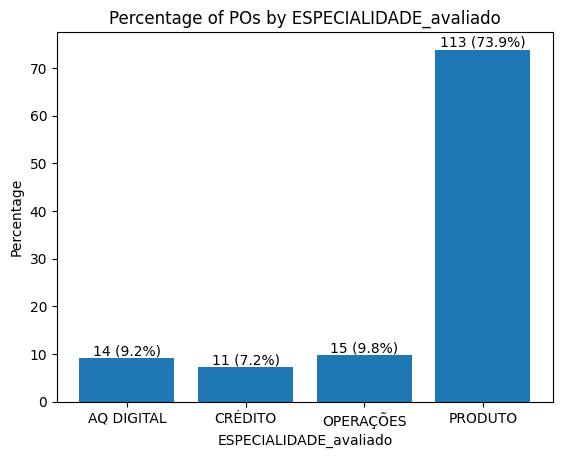

In [ ]:
# Calculate the counts
counts = df[['ESPECIALIDADE_avaliado']][(df['Papel_comunidade'] == 'PO') & (df['ESPECIALIDADE_avaliado'].isin(['OPERAÇÕES', 'AQ DIGITAL', 'CRÉDITO', 'PRODUTO']))].groupby('ESPECIALIDADE_avaliado').size()

# Calculate the percentages
percentages = counts / counts.sum() * 100

# Create a new DataFrame with counts and percentages
result_df = pd.DataFrame({'Count': counts, 'Percentage': percentages})

# Create a bar chart
plt.bar(result_df.index, result_df['Percentage'])
plt.xlabel('ESPECIALIDADE_avaliado')
plt.ylabel('Percentage')
plt.title('Percentage of POs by ESPECIALIDADE_avaliado')
for i, v in enumerate(result_df['Percentage']):
    plt.text(i, v, f"{result_df['Count'][i]} ({v:.1f}%)", ha='center', va='bottom')
plt.show()

No qual esta distribuido em aptos e nao aptos a trabalhar de acordo com a nossa tabela de referencia sao :

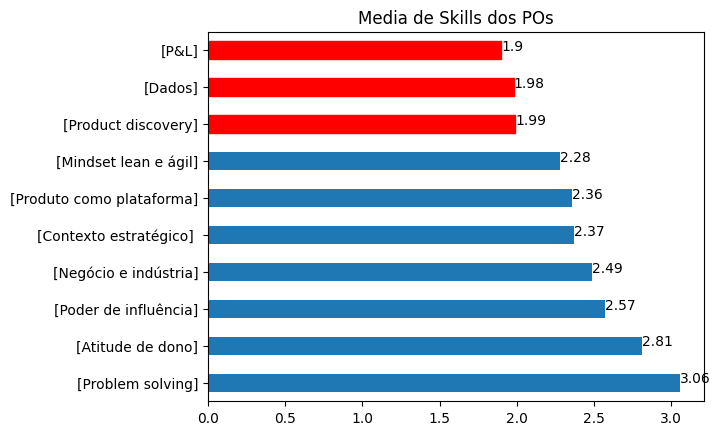

In [ ]:
s = df[df['Papel_comunidade'] == 'PO']
s = s.filter(regex=r'\[').mean().round(2).sort_values(ascending=False)
ax = s.plot.barh()
for i, v in enumerate(s):
    plt.text(v, i, str(v))
    if i >= len(s) - 3:
        ax.get_children()[i].set_color('red')
ax = plt.title('Media de Skills dos POs')